Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')
print("Training data path:\n", data_dir_train)

Training data path:
 /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Number of images in training data: ", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Number of images in testing data: ", image_count_test)

Number of images in training data:  2239
Number of images in testing data:  118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# Import required library
from tensorflow.keras.utils import image_dataset_from_directory

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = image_dataset_from_directory(data_dir_train, labels='inferred', label_mode='categorical', 
                                        batch_size = batch_size, image_size=(img_height,img_width),
                                        shuffle=True, seed = 123, validation_split=0.2, subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = image_dataset_from_directory(data_dir_train, labels='inferred', label_mode='categorical', 
                                      batch_size = batch_size, image_size=(img_height,img_width),
                                      shuffle=True, seed = 123, validation_split=0.2, subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
print(val_ds.class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


BASIC EXPLORATORY DATA ANALYSIS

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
# Creating a dataframe of the image files and their corresponding labels to check the distribution of the data
df_images = pd.DataFrame(columns=["Image_Name","Label"])
for clas in class_names:
  path_class = str(data_dir_train) + '/' + clas + '/'
  all_files = os.listdir(path_class)
  files = []
  for fil in all_files:
    if '.jpg' in fil:
      files.append(fil)
    else:
      None
  l = len(files)
  labels = [clas for i in range(l)]
  temp_df = pd.DataFrame({"Image_Name":files,"Label":labels})
  df_images = pd.concat([df_images,temp_df])


In [ ]:
df_images.shape

(2239, 2)

In [ ]:
df_images.head()

,Image_Name,Label
0,ISIC_0025825.jpg,actinic keratosis
1,ISIC_0027884.jpg,actinic keratosis
2,ISIC_0027580.jpg,actinic keratosis
3,ISIC_0027615.jpg,actinic keratosis
4,ISIC_0027650.jpg,actinic keratosis


In [ ]:
# Now will be Checking the distribution of each class, first in numbers
print("Class distribution in training data:\n")
df_images.Label.value_counts().sort_index()

Class distribution in training data:



actinic keratosis             114
basal cell carcinoma          376
dermatofibroma                 95
melanoma                      438
nevus                         357
pigmented benign keratosis    462
seborrheic keratosis           77
squamous cell carcinoma       181
vascular lesion               139
Name: Label, dtype: int64

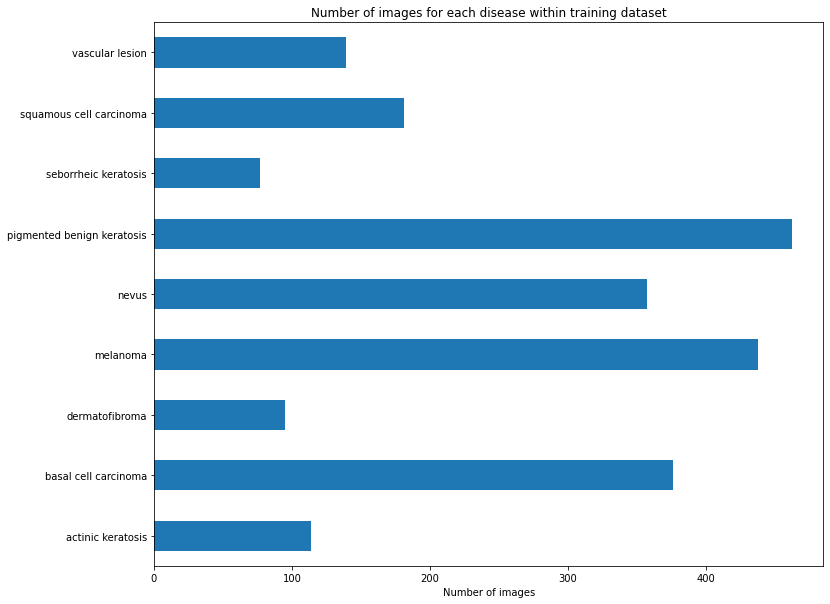

In [ ]:
# Plotting a bar chart of the class distribution
plt.figure(figsize=(12,10))
df_images.Label.value_counts().sort_index().plot.barh()
plt.title("Number of images for each disease within training dataset")
plt.xlabel("Number of images")
plt.show()

Now will be seeing EDA conclusions by having observation on above data:
  
1.   We can see some class imbalance in the dataset, with some classes having much larger number of datapoints than others.

2.   This may affect the training process and would have to be checked if balancing the class weights helps in the training process


  

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

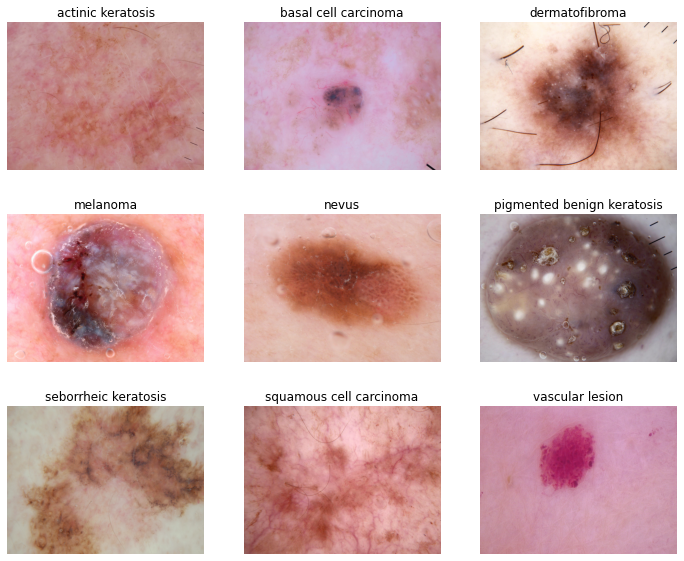

In [ ]:
# Let's display 9 images from the training set, 1 random image from each folder by reading the train directory
plt.figure(figsize=(12,10))
for i in range(9):
  ax = plt.subplot(3,3,i+1)
  rand_idx = np.random.randint(low=1, high=50)
  im = mpimg.imread(str(list(data_dir_train.glob(class_names[i]+ '/*.jpg'))[rand_idx]))
  plt.imshow(im)
  plt.title(class_names[i])
  plt.axis("off")
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [ ]:
# Let's double check the batch sizes
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32, 9)


Now will be Normalizing training and validation data

In [ ]:
# Defining a normalization layer
normal_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
# Applying normalization to training data
train_ds = train_ds.map(lambda x, y: (normal_layer(x), y))
image_batch, labels_batch = next(iter(train_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.046078194 0.75817025


In [ ]:
# Applying normalization to validation data
val_ds = val_ds.map(lambda x, y: (normal_layer(x), y))
image_batch, labels_batch = next(iter(val_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.014221026 0.99915177


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Creating the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

Now Findings if there is an evidence of model overfit or underfit

In [ ]:
# Defining number of classes
number_classes_model = 9



# Model 1


In [ ]:
model1 = Sequential([layers.Layer(input_shape = (img_height, img_width, 3))])

model1.add(Conv2D(16, kernel_size=(3,3), padding ='same', activation = 'relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(32, kernel_size=(3,3), padding ='same', activation = 'relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(64, kernel_size=(3,3), padding ='same', activation = 'relu'))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())
model1.add(Dense(128, activation = 'relu'))

model1.add(Dense(number_classes_model, activation = 'softmax'))

# View the summary of all layers
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer (Layer)               (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Compiling and Fitting the model 1


In [ ]:
# Compiling model 1
model1.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting model 1
epochs = 20
history1 = model1.fit(train_ds, 
                      validation_data=val_ds,
                      epochs=epochs, 
                      verbose = 1, shuffle = True)

Epoch 1/20
56/56 [==============================] - 167s 363ms/step - loss: 2.0644 - accuracy: 0.2076 - val_loss: 2.0450 - val_accuracy: 0.1790
Epoch 2/20
56/56 [==============================] - 3s 47ms/step - loss: 2.0218 - accuracy: 0.2238 - val_loss: 1.9989 - val_accuracy: 0.3423
Epoch 3/20
56/56 [==============================] - 3s 46ms/step - loss: 1.9979 - accuracy: 0.2545 - val_loss: 2.0157 - val_accuracy: 0.1946
Epoch 4/20
56/56 [==============================] - 3s 47ms/step - loss: 1.9619 - accuracy: 0.2723 - val_loss: 1.9517 - val_accuracy: 0.2506
Epoch 5/20
56/56 [==============================] - 3s 47ms/step - loss: 1.9369 - accuracy: 0.2807 - val_loss: 1.8749 - val_accuracy: 0.3647
Epoch 6/20
56/56 [==============================] - 3s 47ms/step - loss: 1.9027 - accuracy: 0.3058 - val_loss: 1.8338 - val_accuracy: 0.3490
Epoch 7/20
56/56 [==============================] - 3s 47ms/step - loss: 1.8611 - accuracy: 0.3270 - val_loss: 1.7482 - val_accuracy: 0.4027
Epoch 8/20

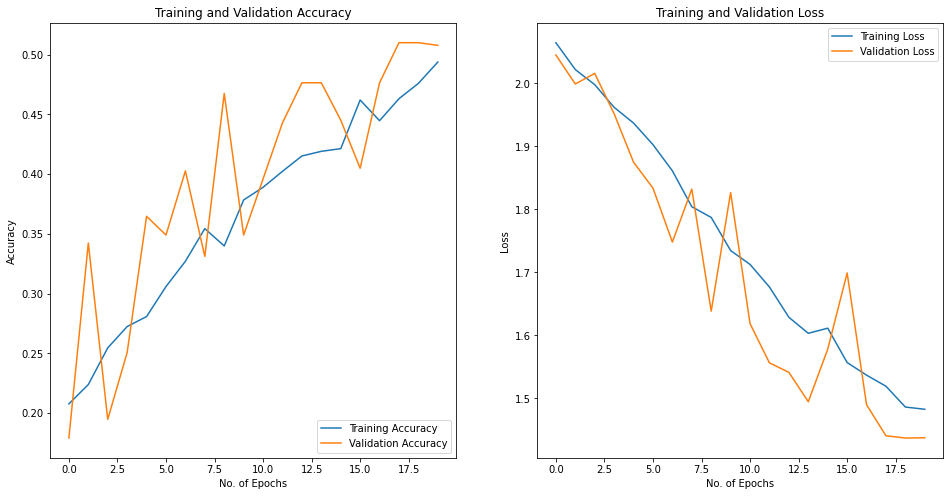

In [ ]:
# Plotting the results of above data
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("No. of Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("No. of Epochs")

plt.show()

Model 1 results after 20 epochs

1.   Training accuracy: 0.4202
2.   Validation accuracy: 0.4116

# Model 2

In [ ]:
model2 = Sequential([layers.Layer(input_shape = (img_height, img_width, 3))])

model2.add(Conv2D(16, kernel_size=(3,3), padding ='same', activation = 'relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(32, kernel_size=(3,3), padding ='same', activation = 'relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(64, kernel_size=(3,3), padding ='same', activation = 'relu'))
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Flatten())
model2.add(Dense(128, activation = 'relu'))
model2.add(Dense(number_classes_model, activation = 'softmax'))


In [ ]:
# View the summary of all layers
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_1 (Layer)             (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

### Compiling and Fitting the model 2

In [ ]:
# Compiling model 2
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting model 2
epochs = 20
history2 = model2.fit(train_ds, 
                      validation_data=val_ds,
                      epochs=epochs, 
                      verbose = 1, shuffle = True)

Epoch 1/20
56/56 [==============================] - 4s 51ms/step - loss: 2.0508 - accuracy: 0.2305 - val_loss: 1.8888 - val_accuracy: 0.3020
Epoch 2/20
56/56 [==============================] - 3s 50ms/step - loss: 1.7626 - accuracy: 0.3711 - val_loss: 1.5574 - val_accuracy: 0.4497
Epoch 3/20
56/56 [==============================] - 3s 47ms/step - loss: 1.5622 - accuracy: 0.4381 - val_loss: 1.4346 - val_accuracy: 0.5369
Epoch 4/20
56/56 [==============================] - 3s 47ms/step - loss: 1.4132 - accuracy: 0.5140 - val_loss: 1.4676 - val_accuracy: 0.4855
Epoch 5/20
56/56 [==============================] - 3s 47ms/step - loss: 1.3199 - accuracy: 0.5385 - val_loss: 1.4430 - val_accuracy: 0.4899
Epoch 6/20
56/56 [==============================] - 3s 47ms/step - loss: 1.2722 - accuracy: 0.5508 - val_loss: 1.3486 - val_accuracy: 0.5414
Epoch 7/20
56/56 [==============================] - 3s 47ms/step - loss: 1.1527 - accuracy: 0.5831 - val_loss: 1.3473 - val_accuracy: 0.5347
Epoch 8/20
56

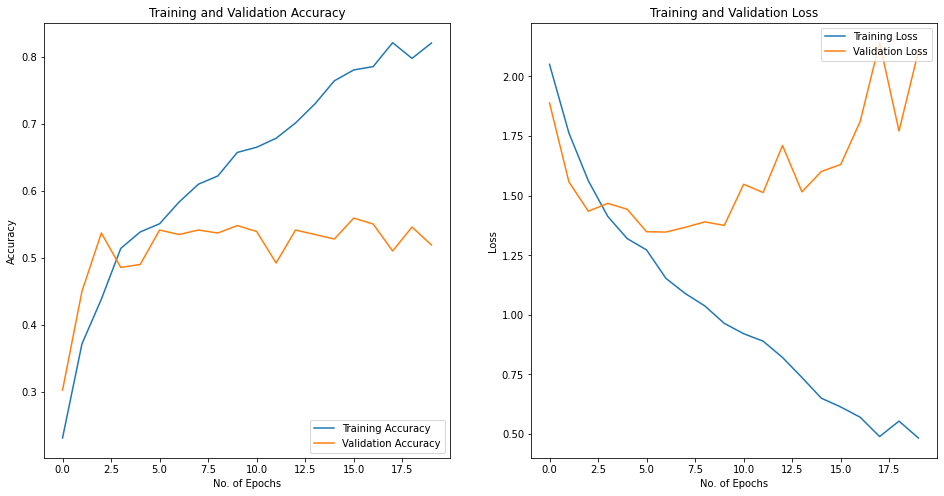

In [ ]:
# Plotting the results
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("No. of Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("No. of Epochs")

plt.show()

Model 2 results after 20 epochs
1.  Training accuracy: 0.8823
2.  Validation accuracy: 0.5347



# Model 3

In [ ]:
model3 = Sequential([layers.Layer(input_shape = (img_height, img_width, 3))])
model3.add(Conv2D(16, kernel_size=(3,3), padding ='same', activation = 'relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(32, kernel_size=(3,3), padding ='same', activation = 'relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(64, kernel_size=(3,3), padding ='same', activation = 'relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Conv2D(128, kernel_size=(3,3), padding ='same', activation = 'relu'))
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Flatten())
model3.add(Dense(256, activation = 'relu'))

model3.add(Dense(number_classes_model, activation = 'softmax'))

# View the summary of all layers
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_3 (Layer)             (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 45, 45, 64)       

#### Compiling and fitting the model 3

In [ ]:
# Compiling model 3 with optimizer 'adam'
model3.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting model 3
epochs = 20
history3 = model3.fit(train_ds, 
                      validation_data=val_ds,
                      epochs=epochs, 
                      verbose = 1, shuffle = True)

Epoch 1/20
56/56 [==============================] - 4s 57ms/step - loss: 2.0279 - accuracy: 0.2232 - val_loss: 1.9347 - val_accuracy: 0.2796
Epoch 2/20
56/56 [==============================] - 3s 52ms/step - loss: 1.8412 - accuracy: 0.3075 - val_loss: 1.6903 - val_accuracy: 0.3937
Epoch 3/20
56/56 [==============================] - 3s 52ms/step - loss: 1.6583 - accuracy: 0.4196 - val_loss: 1.6749 - val_accuracy: 0.4072
Epoch 4/20
56/56 [==============================] - 3s 52ms/step - loss: 1.5793 - accuracy: 0.4453 - val_loss: 1.5023 - val_accuracy: 0.4855
Epoch 5/20
56/56 [==============================] - 3s 52ms/step - loss: 1.4620 - accuracy: 0.4794 - val_loss: 1.7331 - val_accuracy: 0.4004
Epoch 6/20
56/56 [==============================] - 3s 52ms/step - loss: 1.4594 - accuracy: 0.4821 - val_loss: 1.4288 - val_accuracy: 0.5056
Epoch 7/20
56/56 [==============================] - 3s 52ms/step - loss: 1.3013 - accuracy: 0.5430 - val_loss: 1.3631 - val_accuracy: 0.5347
Epoch 8/20
56

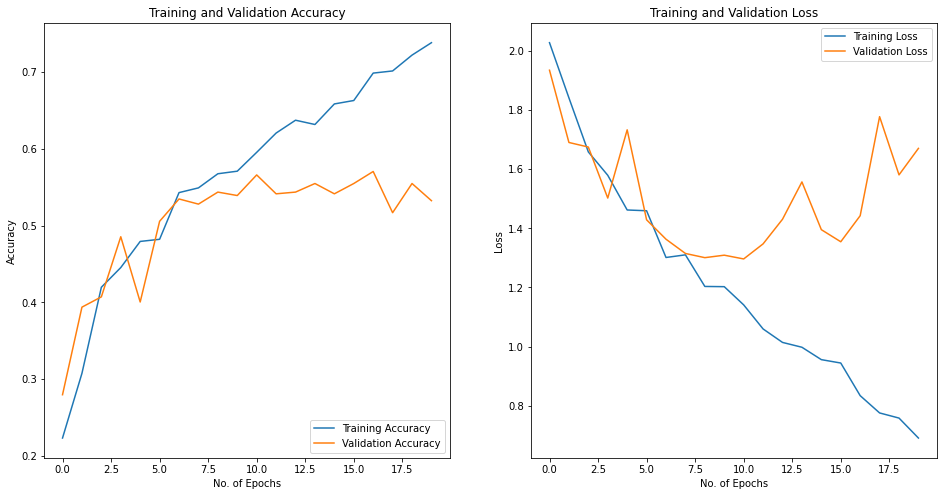

In [ ]:
# Plotting the results
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("No. of Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("No. of Epochs")

plt.show()

Model 3 results after 20 epochs
1.   Training accuracy: 0.8209
2.   Validation accuracy: 0.5078




# MOdel 4

In [ ]:
model4 = Sequential([layers.Layer(input_shape = (img_height, img_width, 3))])
model4.add(Conv2D(16, kernel_size=(3,3), padding ='same', activation = 'relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Conv2D(32, kernel_size=(3,3), padding ='same', activation = 'relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Conv2D(64, kernel_size=(3,3), padding ='same', activation = 'relu'))
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Flatten())
model4.add(Dense(128, activation = 'relu'))
model4.add(Dense(256, activation = 'relu'))
model4.add(Dense(number_classes_model, activation = 'softmax'))

# View the summary of all layers
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_4 (Layer)             (None, 180, 180, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 45, 45, 64)       

In [ ]:
# Compiling model 4
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting model 4
epochs = 20
history4 = model4.fit(train_ds, 
                      validation_data=val_ds,
                      epochs=epochs, 
                      verbose = 1, shuffle = True)

Epoch 1/20
56/56 [==============================] - 4s 51ms/step - loss: 1.9775 - accuracy: 0.2556 - val_loss: 1.8412 - val_accuracy: 0.2774
Epoch 2/20
56/56 [==============================] - 3s 47ms/step - loss: 1.6842 - accuracy: 0.3956 - val_loss: 1.5307 - val_accuracy: 0.4676
Epoch 3/20
56/56 [==============================] - 3s 47ms/step - loss: 1.4510 - accuracy: 0.4922 - val_loss: 1.4838 - val_accuracy: 0.4877
Epoch 4/20
56/56 [==============================] - 3s 47ms/step - loss: 1.3523 - accuracy: 0.5067 - val_loss: 1.3822 - val_accuracy: 0.5436
Epoch 5/20
56/56 [==============================] - 3s 47ms/step - loss: 1.2858 - accuracy: 0.5541 - val_loss: 1.5679 - val_accuracy: 0.4474
Epoch 6/20
56/56 [==============================] - 3s 48ms/step - loss: 1.2424 - accuracy: 0.5597 - val_loss: 1.4260 - val_accuracy: 0.5324
Epoch 7/20
56/56 [==============================] - 3s 47ms/step - loss: 1.1334 - accuracy: 0.5915 - val_loss: 1.4588 - val_accuracy: 0.5011
Epoch 8/20
56

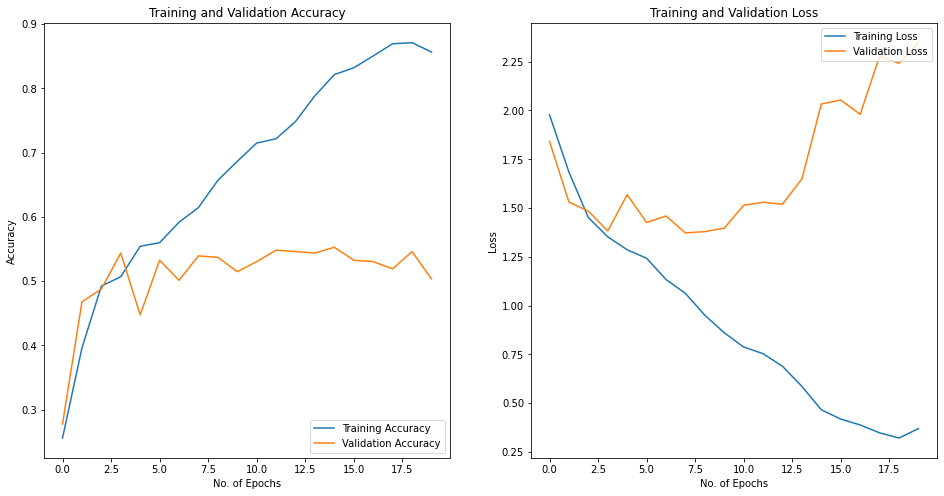

In [ ]:
# Plotting the results
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("No. of Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("No. of Epochs")

plt.show()

Model 4 results after 20 epochs

1.  Training accuracy: 0.8828
2.  Validation accuracy: 0.5123

### Now as we assess some above models so now will be sdding Regularization to the model

# Model 5

In [ ]:
model5 = Sequential([layers.Layer(input_shape = (img_height, img_width, 3))])

model5.add(Conv2D(16, kernel_size=(3,3), padding ='same', activation = 'relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))
model5.add(Dropout(0.1))

model5.add(Conv2D(32, kernel_size=(3,3), padding ='same', activation = 'relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))
model5.add(Dropout(0.1))

model5.add(Conv2D(64, kernel_size=(3,3), padding ='same', activation = 'relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))
model5.add(Dropout(0.2))

model5.add(Flatten())
model5.add(Dense(128, activation = 'relu'))
model5.add(BatchNormalization())
model5.add(Dropout(0.5))
model5.add(Dense(number_classes_model, activation = 'softmax'))

# View the summary of all layers
model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_5 (Layer)             (None, 180, 180, 3)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 90, 90, 32)       

In [ ]:
# Compiling model 5
model5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting model 5
epochs = 20
history5 = model5.fit(train_ds, 
                      validation_data=val_ds,
                      epochs=epochs, 
                      verbose = 1, shuffle = True)

Epoch 1/20
56/56 [==============================] - 4s 63ms/step - loss: 1.5617 - accuracy: 0.4810 - val_loss: 12.5331 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 3s 62ms/step - loss: 1.4017 - accuracy: 0.5285 - val_loss: 4.0544 - val_accuracy: 0.1991
Epoch 3/20
56/56 [==============================] - 3s 61ms/step - loss: 1.3483 - accuracy: 0.5580 - val_loss: 6.7159 - val_accuracy: 0.1119
Epoch 4/20
56/56 [==============================] - 3s 62ms/step - loss: 1.2254 - accuracy: 0.5887 - val_loss: 8.4100 - val_accuracy: 0.1700
Epoch 5/20
56/56 [==============================] - 3s 61ms/step - loss: 1.0100 - accuracy: 0.6462 - val_loss: 9.8288 - val_accuracy: 0.1812
Epoch 6/20
56/56 [==============================] - 4s 64ms/step - loss: 0.8691 - accuracy: 0.6875 - val_loss: 2.8545 - val_accuracy: 0.3020
Epoch 7/20
56/56 [==============================] - 4s 65ms/step - loss: 0.7201 - accuracy: 0.7483 - val_loss: 1.6306 - val_accuracy: 0.4609
Epoch 8/20
5

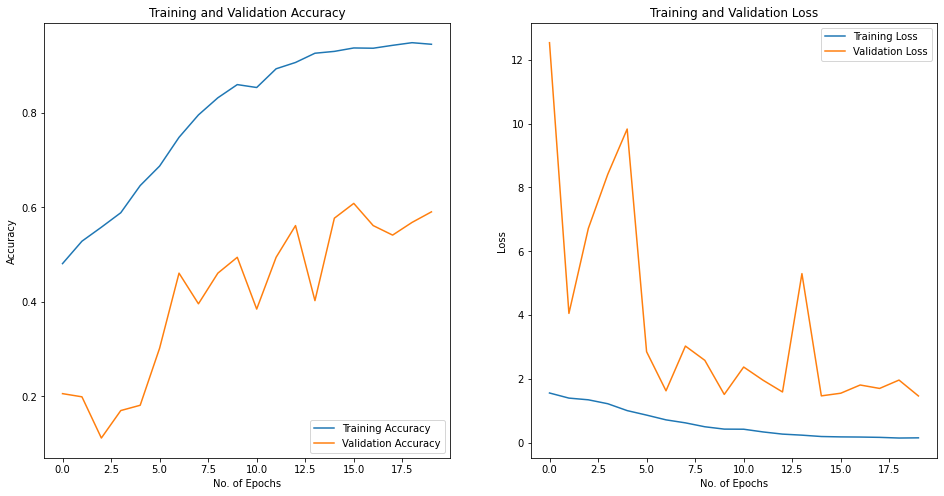

In [ ]:
# Plotting the results
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']

loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("No. of Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("No. of Epochs")

plt.show()

Model 5 results after 20 epochs

1.   Training accuracy: 0.9202
2.   Validation accuracy: 0.5235

# MOdel 6

In [ ]:
# Import L2 regularization
from tensorflow.keras.regularizers import l2

In [ ]:
model6 = Sequential([layers.Layer(input_shape = (img_height, img_width, 3))])

model6.add(Conv2D(16, kernel_size=(3,3), padding ='same', activation = 'relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling2D(pool_size=(2,2)))
model6.add(Dropout(0.2))

model6.add(Conv2D(32, kernel_size=(3,3), padding ='same', activation = 'relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling2D(pool_size=(2,2)))
model6.add(Dropout(0.2))

model6.add(Conv2D(64, kernel_size=(3,3), padding ='same', activation = 'relu'))
model6.add(BatchNormalization())
model6.add(MaxPooling2D(pool_size=(2,2)))
model6.add(Dropout(0.3))

model6.add(Flatten())
model6.add(Dense(128, activation = 'relu', kernel_regularizer=l2(0.01)))
model6.add(BatchNormalization())
model6.add(Dropout(0.5))
model6.add(Dense(number_classes_model, activation = 'softmax'))

# View the summary of all layers
model6.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_9 (Layer)             (None, 180, 180, 3)       0         
                                                                 
 conv2d_32 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_17 (Bat  (None, 180, 180, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 90, 90, 16)        0         
                                                                 
 conv2d_33 (Conv2D)          (None, 90, 90, 32)       

In [ ]:
# Compiling model 6
model6.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Fitting model 9
epochs = 20
history6 = model6.fit(train_ds, 
                      validation_data=val_ds,
                      epochs=epochs, 
                      verbose = 1, shuffle = True)

Epoch 1/20
56/56 [==============================] - 5s 68ms/step - loss: 5.1776 - accuracy: 0.3477 - val_loss: 12.4996 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 4s 63ms/step - loss: 4.0523 - accuracy: 0.4336 - val_loss: 12.5650 - val_accuracy: 0.1544
Epoch 3/20
56/56 [==============================] - 4s 63ms/step - loss: 3.1247 - accuracy: 0.4621 - val_loss: 13.4994 - val_accuracy: 0.1566
Epoch 4/20
56/56 [==============================] - 4s 63ms/step - loss: 2.7060 - accuracy: 0.5078 - val_loss: 8.2814 - val_accuracy: 0.0626
Epoch 5/20
56/56 [==============================] - 4s 65ms/step - loss: 2.4097 - accuracy: 0.5223 - val_loss: 5.0961 - val_accuracy: 0.0783
Epoch 6/20
56/56 [==============================] - 4s 65ms/step - loss: 2.4918 - accuracy: 0.5056 - val_loss: 4.2409 - val_accuracy: 0.1902
Epoch 7/20
56/56 [==============================] - 4s 69ms/step - loss: 2.2404 - accuracy: 0.5547 - val_loss: 2.8846 - val_accuracy: 0.3043
Epoch 8/20

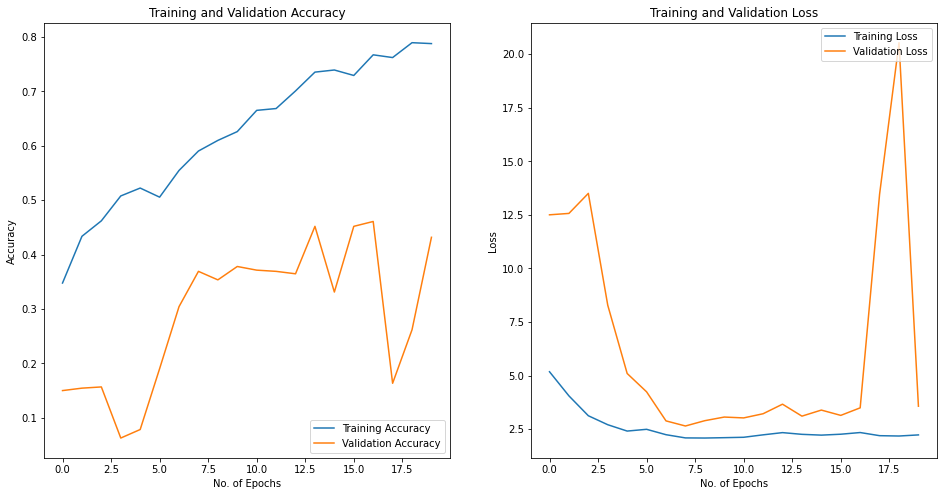

In [ ]:
# Plotting the results
acc = history6.history['accuracy']
val_acc = history6.history['val_accuracy']

loss = history6.history['loss']
val_loss = history6.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("No. of Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("No. of Epochs")

plt.show()

Findings after regularization tests: 

*   Applying regularization (Dropouts + L2 in fully-connected layer) helps with the overfitting issue to some extent encountered with earlier models.
*  However, the validation accuracy values are fairly low. There may be a couple of reasons that may be causing this.


*   Image samples in training dataset within a class may be similar to each other. Might call for data augmentation strategies like random flipping, rotation or zoom.
*   Class imbalance: As we have already seen earlier, there is some class imbalance in the dataset. This might be addressed by upsampling the classes with lesser number of data points.

*   Both of the above issues might need to be addressed to obtain more useful results.
*   Simpler models seem to perform equally well (or poorly) as more complex deeper / wider models. Hence, we shall proceed with simple models initially with augmented data

### Data Augmentation check

In [ ]:
data_augment = Sequential([
                       layers.experimental.preprocessing.Rescaling(1. * 255, input_shape = (img_height, img_width, 3)),
                       layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                       layers.experimental.preprocessing.RandomRotation(0.3),
                       layers.experimental.preprocessing.RandomZoom(0.1)])

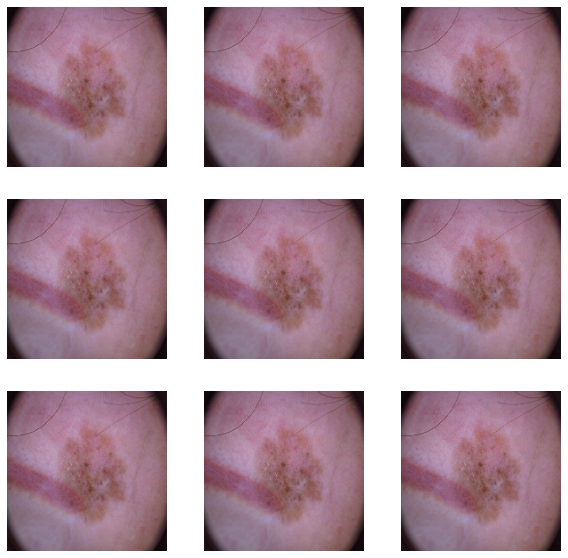

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augment(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
plt.show()

# Model 7

In [ ]:
model7 = Sequential([layers.Layer(input_shape = (img_height, img_width, 3))])

model7.add(layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))
model7.add(layers.experimental.preprocessing.RandomRotation(0.3))
model7.add(layers.experimental.preprocessing.RandomZoom(0.1))

model7.add(Conv2D(16, kernel_size=(3,3), padding ='same', activation = 'relu'))
model7.add(BatchNormalization())
model7.add(MaxPooling2D(pool_size=(2,2)))
model7.add(Dropout(0.2))

model7.add(Conv2D(32, kernel_size=(3,3), padding ='same', activation = 'relu'))
model7.add(BatchNormalization())
model7.add(MaxPooling2D(pool_size=(2,2)))
model7.add(Dropout(0.2))

model7.add(Conv2D(64, kernel_size=(3,3), padding ='same', activation = 'relu'))
model7.add(BatchNormalization())
model7.add(MaxPooling2D(pool_size=(2,2)))
model7.add(Dropout(0.3))

model7.add(Flatten())
model7.add(Dense(128, activation = 'relu'))
model7.add(BatchNormalization())
model7.add(Dropout(0.5))
model7.add(Dense(number_classes_model, activation = 'softmax'))

# View the summary of all layers
model7.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_10 (Layer)            (None, 180, 180, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_21 (Bat  (None, 180, 180, 16)     64        
 chNormalization)                                    

In [ ]:
# Compiling model 12
model7.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
# Fitting model 12
epochs = 30
history7 = model7.fit(train_ds, 
                        validation_data=val_ds,
                        epochs=epochs, 
                        verbose = 1, shuffle = True)

Epoch 1/30
56/56 [==============================] - 6s 76ms/step - loss: 2.1928 - accuracy: 0.3583 - val_loss: 7.6708 - val_accuracy: 0.1477
Epoch 2/30
56/56 [==============================] - 4s 70ms/step - loss: 1.8035 - accuracy: 0.4219 - val_loss: 15.4449 - val_accuracy: 0.1454
Epoch 3/30
56/56 [==============================] - 4s 69ms/step - loss: 1.7025 - accuracy: 0.4537 - val_loss: 12.4998 - val_accuracy: 0.0492
Epoch 4/30
56/56 [==============================] - 4s 69ms/step - loss: 1.5942 - accuracy: 0.4727 - val_loss: 16.8572 - val_accuracy: 0.1230
Epoch 5/30
56/56 [==============================] - 4s 69ms/step - loss: 1.5205 - accuracy: 0.4860 - val_loss: 13.7591 - val_accuracy: 0.1477
Epoch 6/30
56/56 [==============================] - 4s 69ms/step - loss: 1.4506 - accuracy: 0.5061 - val_loss: 7.5106 - val_accuracy: 0.1678
Epoch 7/30
56/56 [==============================] - 4s 69ms/step - loss: 1.4461 - accuracy: 0.4955 - val_loss: 16.2362 - val_accuracy: 0.1253
Epoch 8/

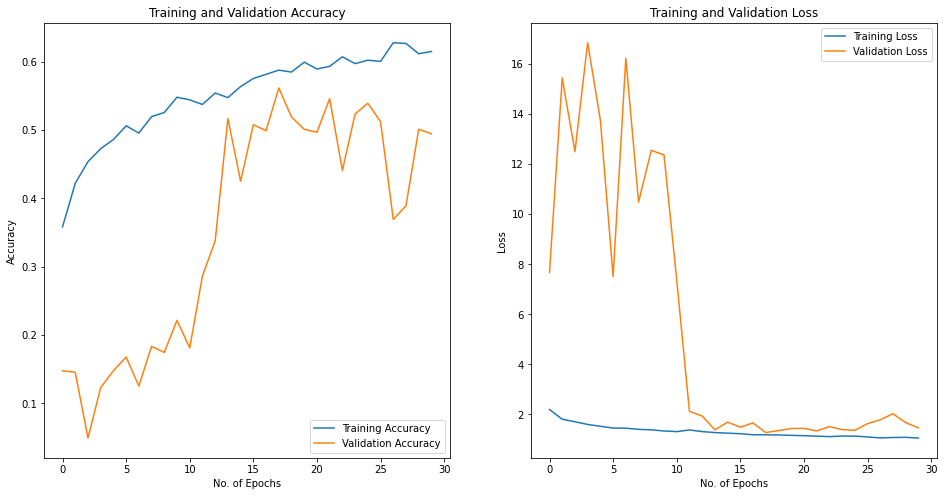

In [ ]:
# Plotting the results
acc = history7.history['accuracy']
val_acc = history7.history['val_accuracy']

loss = history7.history['loss']
val_loss = history7.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("No. of Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("No. of Epochs")

plt.show()

Model 12 results after 30 epochs:

1.   Training accuracy: 0.6099
2.   Validation accuracy: 0.5570

The data augmentation strategies seem to have further reduced overfitting.

In [ ]:
# Displaying the first five rows of the dataframe
df_images.head()

,Image_Name,Label
0,ISIC_0025825.jpg,actinic keratosis
1,ISIC_0027884.jpg,actinic keratosis
2,ISIC_0027580.jpg,actinic keratosis
3,ISIC_0027615.jpg,actinic keratosis
4,ISIC_0027650.jpg,actinic keratosis


In [ ]:
df_images.Label.value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

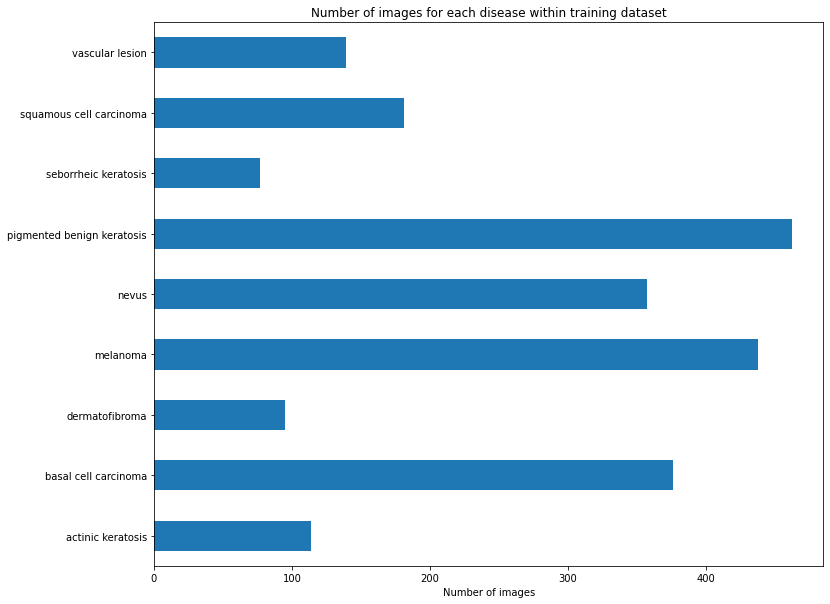

In [ ]:
# Plotting a bar chart of the class distribution
plt.figure(figsize=(12,10))
df_images.Label.value_counts().sort_index().plot.barh()
plt.title("Number of images for each disease within training dataset")
plt.xlabel("Number of images")
plt.show()

**Conclusions**:

1.   We can see some class imbalance in the dataset, with some classes having much larger number of datapoints than others.
2.   This may affect the training process and would have to be checked if balancing the class distribution helps in the training accuracies.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
# Using Augmentor to address class imbalance
path_to_training_dataset = "/content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(source_directory= path_to_training_dataset + i)
    # Adding a rotation operation to the pipeline
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F75C1D53ED0>: 100%|██████████| 500/500 [00:26<00:00, 19.22 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F75C1D4D050>: 100%|██████████| 500/500 [00:22<00:00, 22.20 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F75C21DCCD0>: 100%|██████████| 500/500 [00:22<00:00, 22.01 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F75C1D4B810>: 100%|██████████| 500/500 [01:47<00:00,  4.64 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7F75C14CC410>: 100%|██████████| 500/500 [01:49<00:00,  4.58 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F75C1D49BD0>: 100%|██████████| 500/500 [00:25<00:00, 19.98 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F75C1581150>: 100%|██████████| 500/500 [00:51<00:00,  9.65 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F75C158A790>: 100%|██████████| 500/500 [00:24<00:00, 20.74 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F75C1D60910>: 100%|██████████| 500/500 [00:22<00:00, 22.28 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train_new = len(list(data_dir_train.glob("*/*.jpg"))) + len(list(data_dir_train.glob("*/output/*.jpg")))
print("Total images after augmentation (original + augmented): ", image_count_train_new)

Total images after augmentation (original + augmented):  6739


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in data_dir_train.glob('*/output/*.jpg')]
path_list_new

[PosixPath('/content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027884.jpg_dfe1198d-e5a9-453f-a610-aece5a598858.jpg'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031228.jpg_2a881c87-d166-4f8c-ab03-a94713b10fa4.jpg'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029133.jpg_d549f9d2-bcfb-47b7-bb80-bc11280e5e59.jpg'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033151.jpg_9fc17c5b-9f85-4375-aa85-8803aab199a8.jpg'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/Skin cancer

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in data_dir_train.glob('*/output/*.jpg')]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
# Dataframe with details of augmented images
df_images2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ["Image_Name","Label"])

# Combined dataframe of details of original and augmented images
new_df = df_images.append(df_images2)

In [ ]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

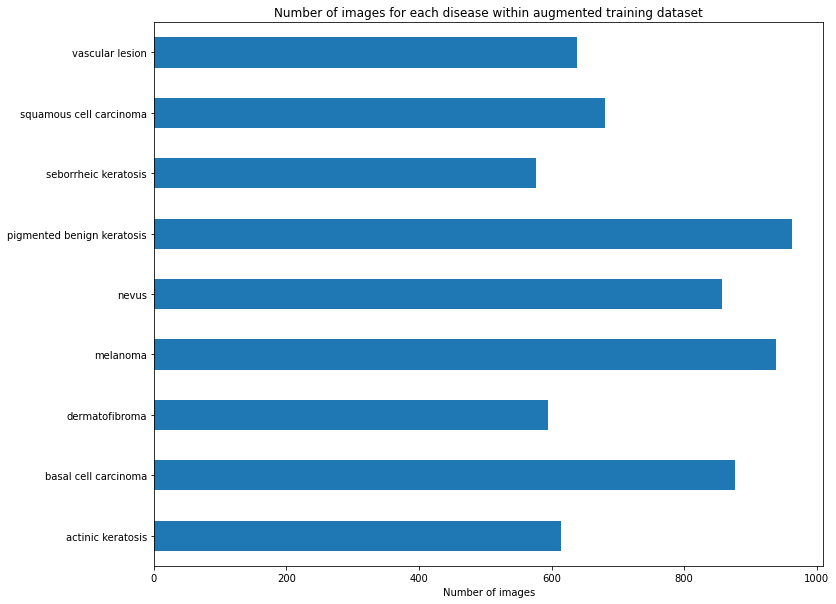

In [ ]:
# Plotting a bar chart of the new class distribution
plt.figure(figsize=(12,10))
new_df.Label.value_counts().sort_index().plot.barh()
plt.title("Number of images for each disease within augmented training dataset")
plt.xlabel("Number of images")
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
# Import required library
from tensorflow.keras.utils import image_dataset_from_directory

In [ ]:
train_ds_aug = image_dataset_from_directory(data_dir_train, labels='inferred', label_mode='categorical',
                                            batch_size = batch_size, image_size=(img_height,img_width),
                                            shuffle=True, seed = 123, validation_split=0.2, subset='training')

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


Create a validation dataset

In [ ]:
val_ds_aug = image_dataset_from_directory(data_dir_train, labels='inferred', label_mode='categorical',
                                           batch_size = batch_size, image_size=(img_height,img_width),
                                           shuffle=True, seed = 123, validation_split=0.2, subset='validation')

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Normalizing the augmented dataset.

In [ ]:
# Defining a normalization layer
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
# Applying normalization to training data
train_ds_aug = train_ds_aug.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train_ds_aug))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.23022896 0.9650329


In [ ]:
# Applying normalization to validation data
val_ds_aug = val_ds_aug.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(val_ds_aug))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0075163003 0.79003274


In [ ]:
# Configuring the dataset for performance, so that I/O does not become a bottleneck
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds_aug = train_ds_aug.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_aug = val_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)

# Model 8

In [ ]:
# Model 8
# Relatively simple architecture with 3 convolution layers and one Fully-Connected layer.
# Using augmented dataset with better class distribution than earlier

model8 = Sequential([layers.Layer(input_shape = (img_height, img_width, 3))])

model8.add(layers.experimental.preprocessing.RandomFlip("horizontal"))
model8.add(layers.experimental.preprocessing.RandomRotation(0.1))
model8.add(layers.experimental.preprocessing.RandomZoom(0.1))

model8.add(Conv2D(16, kernel_size=(3,3), padding ='same', activation = 'relu'))
model8.add(BatchNormalization())
model8.add(MaxPooling2D(pool_size=(2,2)))

model8.add(Conv2D(32, kernel_size=(3,3), padding ='same', activation = 'relu'))
model8.add(BatchNormalization())
model8.add(MaxPooling2D(pool_size=(2,2)))

model8.add(Conv2D(64, kernel_size=(3,3), padding ='same', activation = 'relu'))
model8.add(BatchNormalization())
model8.add(MaxPooling2D(pool_size=(2,2)))
model8.add(Dropout(0.3))

model8.add(Flatten())
model8.add(Dense(128, activation = 'relu'))
model8.add(BatchNormalization())
model8.add(Dropout(0.5))
model8.add(Dense(number_classes_model, activation = 'softmax'))

# View the summary of all layers
model8.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_11 (Layer)            (None, 180, 180, 3)       0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_38 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_25 (Bat  (None, 180, 180, 16)     64        
 chNormalization)                                    

In [ ]:
# Compiling model 13
model8.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
# Fitting model 13
epochs = 50
history8 = model8.fit(train_ds_aug, 
                      validation_data=val_ds_aug,
                      epochs=epochs, 
                      verbose = 1, shuffle = True)

Epoch 1/50
169/169 [==============================] - 61s 124ms/step - loss: 2.0125 - accuracy: 0.3490 - val_loss: 2.7057 - val_accuracy: 0.1173
Epoch 2/50
169/169 [==============================] - 11s 64ms/step - loss: 1.6499 - accuracy: 0.4225 - val_loss: 2.3820 - val_accuracy: 0.2509
Epoch 3/50
169/169 [==============================] - 11s 64ms/step - loss: 1.4350 - accuracy: 0.4824 - val_loss: 1.3554 - val_accuracy: 0.5137
Epoch 4/50
169/169 [==============================] - 11s 64ms/step - loss: 1.3059 - accuracy: 0.5184 - val_loss: 1.6611 - val_accuracy: 0.4239
Epoch 5/50
169/169 [==============================] - 11s 64ms/step - loss: 1.2346 - accuracy: 0.5501 - val_loss: 1.1863 - val_accuracy: 0.5412
Epoch 6/50
169/169 [==============================] - 11s 64ms/step - loss: 1.1637 - accuracy: 0.5660 - val_loss: 1.3245 - val_accuracy: 0.5278
Epoch 7/50
169/169 [==============================] - 11s 63ms/step - loss: 1.1076 - accuracy: 0.5783 - val_loss: 1.0847 - val_accuracy

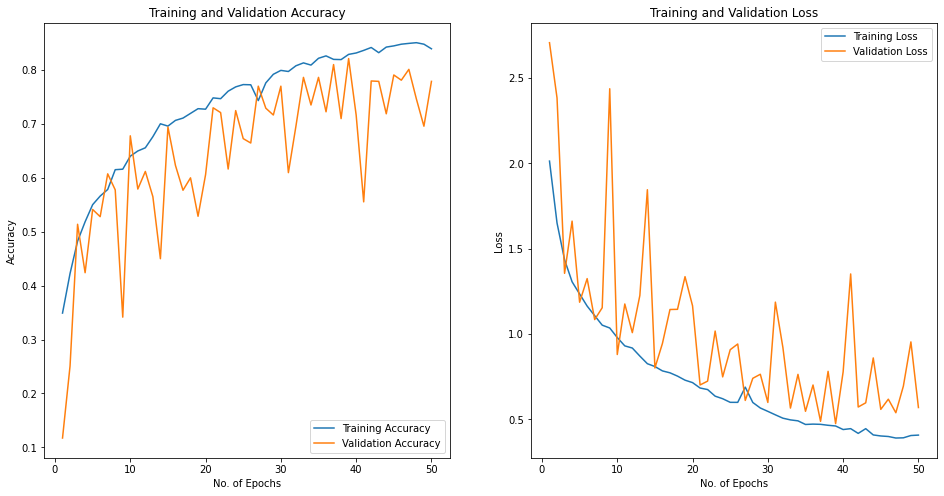

In [ ]:
# Plotting the results
acc = history8.history['accuracy']
val_acc = history8.history['val_accuracy']

loss = history8.history['loss']
val_loss = history8.history['val_loss']

epochs_range = range(1,epochs+1)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("No. of Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("No. of Epochs")

plt.show()

Model 8 conclusions after 50 epochs:

1.  Training accuracy: 0.8390 and Validation accuracy: 0.7788
1.  The training and validation accuracy have increased more or less monotonically with no overfitting.
2.   The validation accuracy is quite erratic. Perhaps a slower learning rate may be able to address it.


# Model 9

In [ ]:
model9 = Sequential([layers.Layer(input_shape = (img_height, img_width, 3))])

model9.add(layers.experimental.preprocessing.RandomFlip("horizontal"))
model9.add(layers.experimental.preprocessing.RandomRotation(0.1))
model9.add(layers.experimental.preprocessing.RandomZoom(0.1))

model9.add(Conv2D(16, kernel_size=(3,3), padding ='same', activation = 'relu'))
model9.add(MaxPooling2D(pool_size=(2,2)))

model9.add(Conv2D(32, kernel_size=(3,3), padding ='same', activation = 'relu'))
model9.add(MaxPooling2D(pool_size=(2,2)))

model9.add(Conv2D(64, kernel_size=(3,3), padding ='same', activation = 'relu'))
model9.add(MaxPooling2D(pool_size=(2,2)))
model9.add(Dropout(0.3))

model9.add(Flatten())
model9.add(Dense(128, activation = 'relu'))
model9.add(Dropout(0.3))
model9.add(Dense(256, activation = 'relu'))
model9.add(Dropout(0.3))
model9.add(Dense(number_classes_model, activation = 'softmax'))

# View the summary of all layers
model9.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_12 (Layer)            (None, 180, 180, 3)       0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_41 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                

In [ ]:
# Compiling model 15 with a higher learning rate than model 14 because batch norm has been removed.
model9.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [104]:
# Fitting model 9 - Using higher number of epochs because batch norm has been removed, which would likely result in a slower training process.
epochs = 100
history9 = model9.fit(train_ds_aug, 
                      validation_data=val_ds_aug,
                      epochs=epochs, 
                      verbose = 1, shuffle = True)

Epoch 1/100
169/169 [==============================] - 11s 58ms/step - loss: 2.0162 - accuracy: 0.2131 - val_loss: 1.7645 - val_accuracy: 0.2977
Epoch 2/100
169/169 [==============================] - 9s 55ms/step - loss: 1.7027 - accuracy: 0.3444 - val_loss: 1.6014 - val_accuracy: 0.3697
Epoch 3/100
169/169 [==============================] - 9s 54ms/step - loss: 1.5560 - accuracy: 0.3969 - val_loss: 1.4017 - val_accuracy: 0.4306
Epoch 4/100
169/169 [==============================] - 10s 57ms/step - loss: 1.4453 - accuracy: 0.4405 - val_loss: 1.3094 - val_accuracy: 0.4833
Epoch 5/100
169/169 [==============================] - 9s 55ms/step - loss: 1.4006 - accuracy: 0.4583 - val_loss: 1.2886 - val_accuracy: 0.4811
Epoch 6/100
169/169 [==============================] - 10s 56ms/step - loss: 1.3356 - accuracy: 0.4798 - val_loss: 1.2266 - val_accuracy: 0.5212
Epoch 7/100
169/169 [==============================] - 9s 54ms/step - loss: 1.3129 - accuracy: 0.4922 - val_loss: 1.2400 - val_accura

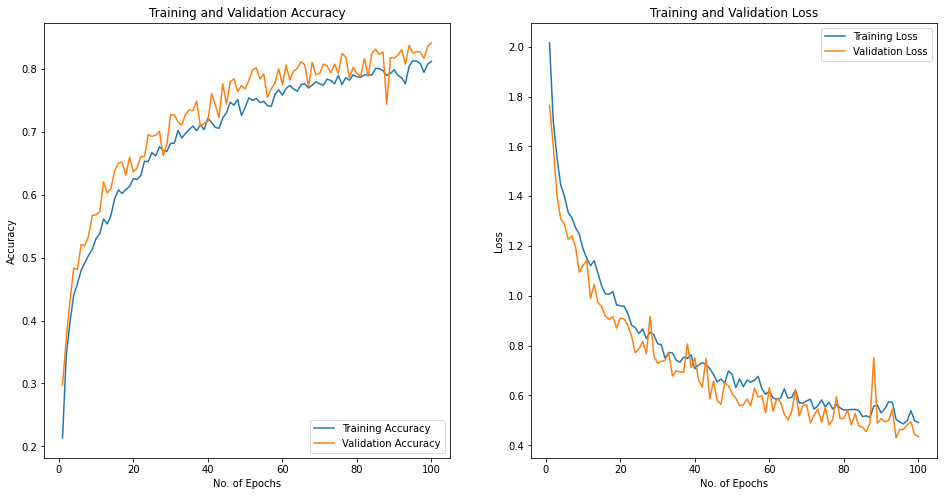

In [105]:
# Plotting the results
acc = history9.history['accuracy']
val_acc = history9.history['val_accuracy']

loss = history9.history['loss']
val_loss = history9.history['val_loss']

epochs_range = range(1,epochs+1)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel("No. of Epochs")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("No. of Epochs")

plt.show()

Model 15 conclusions after 100 epochs are below:
- Training accuracy: 0.8320
- Validation accuracy: 0.8448

- Removal of Batch Normalization results in much slower training even with a faster learning rate. This is the reason to use much higher epochs than the previous model.

- The additional fully connected layer significantly improves the accuracy.
Given better hardware resources, there is the potential to further improve this model with more number of epochs.
- There is practically no overfitting with training and validation accuracies being neck and neck throughout the training process.
This shall be our final model for this assignment due to a paucity of hardware resources. There is certainly scope to further improve the model with deeper networks and more complex architectures

 **Conclusions**

- A more complex model does not necessarily mean better results can be achieved. This is especially true if the dataset has class imbalance and small number of data-points, as was the case with our dataset. Occam's razor is a good principle to follow in this regard, i.e., the simplest model which does the job is probably the most suitable model.

- Batch Normalization can significantly speed up the training process. However, it can sometimes make the learning erratic and hence tests should be performed both with and without batch norm.
Proper regularization strategies like Dropouts make a huge difference in ensuring the model does not overfit.